# CNN w/ Keras on TF

# Set up

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

#for model3
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation

In [4]:
# Load the data
train = pd.read_csv("~/.kaggle/competitions/digit-recognizer/train.csv")
test = pd.read_csv("~/.kaggle/competitions/digit-recognizer/test.csv")

In [5]:
# Define training varible
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1) 

del train 

# Preliminary EDA

### Y-distribution

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

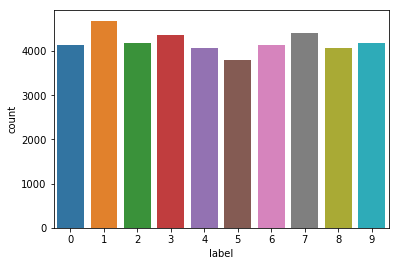

In [6]:
g = sns.countplot(Y_train)
Y_train.value_counts()

### Missing data? No

In [7]:
print X_train.isnull().any().describe()
print 
print sum(Y_train.isnull())
print 
print test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

0

count       784
unique        1
top       False
freq        784
dtype: object


# Data Munging

### Normalization

In [8]:
# We perform a grayscale normalization to reduce the effect of illumination's differences. (not implemented)
# Moreover the CNN converg faster on [0..1] data than on [0..255].
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

### Reshape

In [9]:
# Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.
# Keras requires an extra dimension in the end which correspond to channels. 
# MNIST images are gray scaled so it usonly one channel. For RGB images, there is 3 channels, 
# we would have reshaped 784px vectors to 28x28x3 3D matrices.
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices. 

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices. 

### Label encoding

In [10]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

### Split training and valdiation set 

In [11]:
# Set the random seed
random_seed = 2

# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

We can get a better sense for one of these examples by visualising the image and looking at the label.

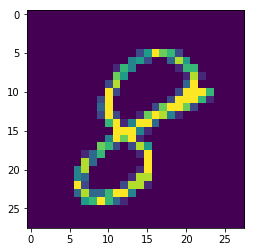

In [12]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

# 3. CNN
## 3.1 Define the model

I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 32 filters for the two firsts conv2D layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important. 

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting. 

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network. 

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [14]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 2 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

img_rows, img_cols = 28, 28

nb_filters_1 = 32 # 64
nb_filters_2 = 64 # 128
nb_filters_3 = 128 # 256
nb_conv = 3
nb_classes = Y_train.shape[1]


In [15]:
# Set the CNN model ( original yassineghouzam )
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

# keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), 
# activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', 
# kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, 
# bias_constraint=None)

model = Sequential()
model.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (5,5),
                 padding = 'Same', 
                 activation ='relu', 
                 input_shape = (28,28,1)))
model.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (5,5),
                 padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (3,3),
                 padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (3,3),
                 padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation = "softmax"))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [16]:
model.summary()

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [17]:
# Without data augmentation i obtained an accuracy of 0.98114
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
         validation_data = (X_val, Y_val), verbose = 2)

# With data augmentation to prevent overfitting (accuracy 0.99286)

# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.1, # Randomly zoom image 
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=False,  # randomly flip images
#         vertical_flip=False)  # randomly flip images


# datagen.fit(X_train)

# Fit the model
# history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
#                               epochs = epochs, validation_data = (X_val,Y_val),
#                               verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
#                               , callbacks=[learning_rate_reduction])

Train on 37800 samples, validate on 4200 samples
Epoch 1/2
148s - loss: 0.2385 - acc: 0.9235 - val_loss: 0.0676 - val_acc: 0.9786
Epoch 2/2
139s - loss: 0.0753 - acc: 0.9778 - val_loss: 0.0617 - val_acc: 0.9821


In [18]:
# translated to new keras version from https://www.kaggle.com/somshubramajumdar/deep-convolutional-network-using-keras
# difference from model: 
#     - smaller kernel_size (3,3) instead of (5,5) for first two conv2d 
#     - YES (MaxPool2D(pool_size=(2,2))) after 1st and 2nd set of conv2d
#           * This layer simply acts as a downsampling filter. 
#           * It looks at the 2 neighboring pixels and picks the maximal value. 
#           * These are used to reduce computational cost, and to some extent also reduce overfitting. 
#           * We have to choose the pooling size (i.e the area size pooled each time) more the pooling 
#             dimension is high, more the downsampling is important.
#           * Combining convolutional and pooling layers, CNN are able to combine local features 
#             and learn more global features of the image.
#     - NO Dropout(0.25) after 1st and 2nd set of conv2d -- JUST AFTER FLATTEN
#           * Dropout is a regularization method, where a proportion of nodes in the layer are 
#             randomly ignored (setting their wieghts to zero) for each training sample. 
#           * This drops randomly a propotion of the network and forces the network to learn features 
#             in a distributed way. 
#           * This technique also improves generalization and reduces the overfitting. 
#             (NOT IMPORTANT IN THIS CASE SINCE TEST==TRAIN)
#     - YES @END FLATTEN & DROPOUT but not sandwhiched by dense layers, dense come after faltten & dropout
#           * The Flatten layer is use to convert the final feature maps into a one single 1D vector. 
#           * This flattening step is needed so that you can make use of fully connected layers after some 
#           * convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.
# USES ADAM INSTEAD OF RMSPROP


# cnn = models.Sequential()
# cnn.add(conv.Convolution2D(nb_filters_1, 
#                            nb_conv, nb_conv,  
#                            activation="relu", 
#                            input_shape=(28, 28, 1), 
#                            border_mode='same'))
# cnn.add(conv.Convolution2D(nb_filters_1, 
#                            nb_conv, 
#                            nb_conv, 
#                            activation="relu", 
#                            border_mode='same'))
# cnn.add(conv.MaxPooling2D(strides=(2,2)))
# cnn.add(conv.Convolution2D(nb_filters_3, nb_conv, nb_conv, activation="relu", border_mode='same'))
# cnn.add(conv.Convolution2D(nb_filters_2, nb_conv, nb_conv, activation="relu", border_mode='same'))
# cnn.add(conv.MaxPooling2D(strides=(2,2)))
# cnn.add(core.Flatten())
# cnn.add(core.Dropout(0.2))
# cnn.add(core.Dense(128, activation="relu")) # 4096
# cnn.add(core.Dense(nb_classes, activation="softmax"))


model2 = Sequential()

model2.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu', 
                 input_shape = (28,28,1)))
model2.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))

model2.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model2.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(strides=(2,2)))

model2.add(Flatten())
model2.add(Dropout(0.2))
model2.add(Dense(128, activation = "relu"))
model2.add(Dense(nb_classes, activation = "softmax"))

model2.summary()

model2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history2 = model2.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,
                     validation_data = (X_val, Y_val), verbose = 2)

In [74]:
# model 3
# https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/

# BATCH NORMALIZATION ADDIED BETWEEN CONV2D AND ACTIVATION
# It’s a best practice to always do BatchNormalization. BatchNormalization normalizes the matrix 
# after it is been through a convolution layer so that the scale of each dimension remains the same. 
# It reduces the training time significantly.



model3 = Sequential()

model3.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model3.add(BatchNormalization(axis=-1))
model3.add(Activation('relu'))
model3.add(Conv2D(32, (3, 3)))
model3.add(BatchNormalization(axis=-1))
model3.add(Activation('relu'))
model3.add(MaxPool2D(pool_size=(2,2)))

model3.add(Conv2D(64,(3, 3)))
model3.add(BatchNormalization(axis=-1))
model3.add(Activation('relu'))
model3.add(Conv2D(64, (3, 3)))
model3.add(BatchNormalization(axis=-1))
model3.add(Activation('relu'))
model3.add(MaxPool2D(pool_size=(2,2)))

model3.add(Flatten())

# Fully connected layer
model3.add(Dense(512))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.2))
model3.add(Dense(10))

model3.add(Activation('softmax'))

In [75]:
model3.summary()

model3.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
# keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
history3 = model3.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,
                     validation_data = (X_val, Y_val), verbose = 2)


# model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_11 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
activation_11 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_12 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
activation_12 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 32)        0         
__________

In [80]:
# adding batch normalization to 2nd model

model4 = Sequential()

model4.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 input_shape = (28,28,1)))
model4.add(BatchNormalization(axis=-1))
model4.add(Activation('relu'))
model4.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same'))
model4.add(BatchNormalization(axis=-1))
model4.add(Activation('relu'))
model4.add(MaxPool2D(pool_size=(2,2)))

model4.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same'))
model4.add(BatchNormalization(axis=-1))
model4.add(Activation('relu'))
model4.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same'))
model4.add(BatchNormalization(axis=-1))
model4.add(Activation('relu'))
model4.add(MaxPool2D(strides=(2,2)))

model4.add(Flatten())
model4.add(Dropout(0.2))
model4.add(Dense(128, activation = "relu"))
model4.add(Dense(nb_classes, activation = "softmax"))

model4.summary()

model4.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history4 = model4.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,
                     validation_data = (X_val, Y_val), verbose = 2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_16 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
activation_17 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_17 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
activation_18 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 32)        0         
__________

## 3.3 Data augmentation 

# 4. Evaluate the model
## 4.1 Training and validation curves

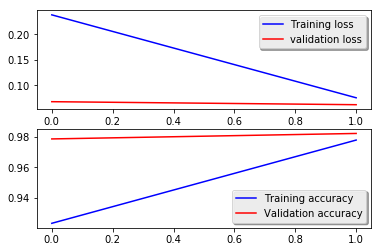

In [29]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

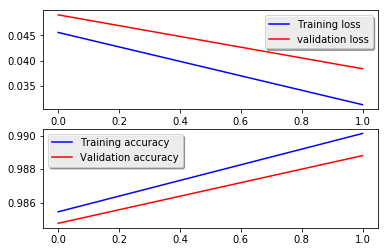

In [30]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history2.history['loss'], color='b', label="Training loss")
ax[0].plot(history2.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history2.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history2.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

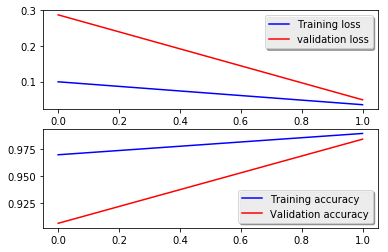

In [76]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history3.history['loss'], color='b', label="Training loss")
ax[0].plot(history3.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history3.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history3.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 4.2 Confusion matrix

In [31]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

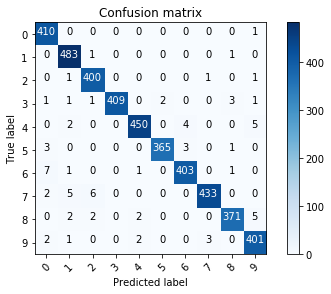

In [32]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

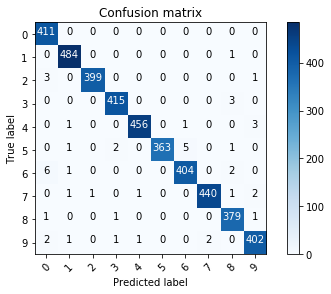

In [33]:
# Predict the values from the validation dataset
Y_pred2 = model2.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes2 = np.argmax(Y_pred2,axis = 1) 
# Convert validation observations to one hot vectors
# Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx2 = confusion_matrix(Y_true, Y_pred_classes2) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx2, classes = range(10)) 

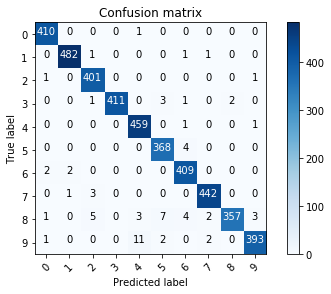

In [77]:
# Predict the values from the validation dataset
Y_pred3 = model3.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes3 = np.argmax(Y_pred3,axis = 1) 
# Convert validation observations to one hot vectors
# Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx3 = confusion_matrix(Y_true, Y_pred_classes3) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx3, classes = range(10)) 

Here we can see that our CNN performs very well on all digits with few errors considering the size of the validation set (4 200 images).

However, it seems that our CNN has some little troubles with the 4 digits, hey are misclassified as 9. Sometime it is very difficult to catch the difference between 4 and 9 when curves are smooth.

Let's investigate for errors. 

I want to see the most important errors . For that purpose i need to get the difference between the probabilities of real value and the predicted ones in the results.

In [55]:
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1


In [56]:
def det_most_important_errors(Y_pred_errors, Y_true_errors, ):
    # Probabilities of the wrong predicted numbers
    Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

    # Predicted probabilities of the true values in the error set
    true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

    # Difference between the probability of the predicted label and the true label
    delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

    # Sorted list of the delta prob errors
    sorted_delta_errors = np.argsort(delta_pred_true_errors)

    return sorted_delta_errors

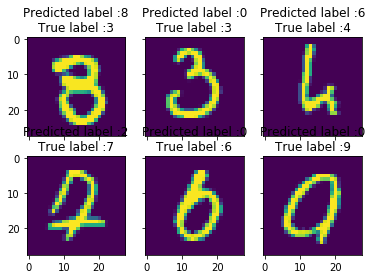

In [58]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

most_important_errors = det_most_important_errors(Y_pred_errors, Y_true_errors)

# Show the top 6 errors
display_errors(most_important_errors[-6:], X_val_errors, Y_pred_classes_errors, Y_true_errors)

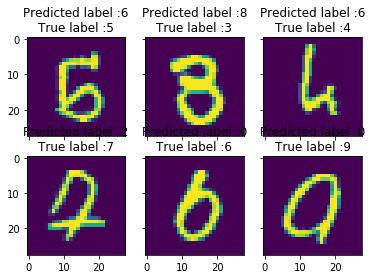

In [59]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors2 = (Y_pred_classes2 - Y_true != 0)

Y_pred_classes_errors2 = Y_pred_classes[errors2]
Y_pred_errors2 = Y_pred[errors2]
Y_true_errors2 = Y_true[errors2]
X_val_errors2 = X_val[errors2]

most_important_errors2 = det_most_important_errors(Y_pred_errors2, Y_true_errors2)

# Show the top 6 errors
display_errors(most_important_errors2[-6:], X_val_errors2, Y_pred_classes_errors2, Y_true_errors2)

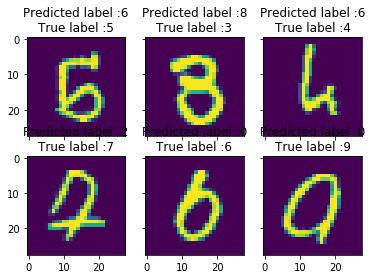

In [79]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors3 = (Y_pred_classes3 - Y_true != 0)

Y_pred_classes_errors3 = Y_pred_classes[errors3]
Y_pred_errors3 = Y_pred[errors3]
Y_true_errors3 = Y_true[errors3]
X_val_errors3 = X_val[errors3]

most_important_errors3 = det_most_important_errors(Y_pred_errors3, Y_true_errors3)

# Show the top 6 errors
display_errors(most_important_errors3[-6:], X_val_errors3, Y_pred_classes_errors3, Y_true_errors3)

In [61]:
most_important_errors

array([57, 52, 67, 27, 33, 31, 64, 18, 56, 72, 55, 26, 47, 71, 36, 65, 15,
       41,  8,  1, 37, 14, 16, 46, 13, 23, 12,  7, 19, 59,  2, 25,  5,  4,
       50, 20, 22, 11, 38, 70, 49, 35, 53, 24, 58,  0, 44, 28, 17, 69, 43,
       48, 73,  6, 61, 66, 63, 29, 30, 42,  3, 34,  9, 32, 60, 40, 51, 10,
       21, 39, 54, 68, 62, 74, 45])

In [62]:
most_important_errors2

array([29, 31, 24, 45, 21, 20, 34, 35, 15, 36, 13, 27, 37, 42,  2,  4, 44,
       40, 17, 30,  1, 10,  7, 11, 32,  5, 19, 28, 14,  0, 23, 43, 26,  6,
       39, 16,  3,  8, 18, 33,  9, 12, 22, 41, 38, 46, 25])

The most important errors are also the most intrigous. 

For those six case, the model is not ridiculous. Some of these errors can also be made by humans, especially for one the 9 that is very close to a 4. The last 9 is also very misleading, it seems for me that is a 0.

In [29]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)

In [60]:
# predict results
results2 = model2.predict(test)

# select the indix with the maximum probability
results2 = np.argmax(results2,axis = 1)

results2 = pd.Series(results2,name="Label")

submission2 = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results2],axis = 1)

submission2.to_csv("cnn_mnist_datagen2.csv",index=False)



** you found this notebook helpful or you just liked it , some upvotes would be very much appreciated - That will keep me motivated :)**
